In [1]:
import chromadb
import pandas as pd
from chromadb.config import Settings
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
csv_file_path = 'data/synthetic_clusters_colored.csv'
data = pd.read_csv(csv_file_path)

In [3]:
client = chromadb.Client()

client.list_collections()

[]

In [4]:
index_configuraiton = {
    "lmi:epochs": "[200]",
    "lmi:model_types": "['MLP']",
    "lmi:lrs": "[0.01]",
    "lmi:n_categories": "[4]"
}

collection_name = "synthetic_collection"
collection = client.create_collection(
    name=collection_name,
    metadata=index_configuraiton
)

In [5]:
# Assuming 'embeddings' are the first three columns
# 'status' is the fourth column, 'document' is the fifth column, and 'id' is the sixth column
collection.add(
    embeddings=data[['x', 'y']].values.tolist(),
    metadatas=[{"cluster": cluster} for cluster in data['cluster']],
    ids=data['id'].values.tolist(),
)

bucket_assignment = collection.build_index()


            LMI Build Config:
            {
                clustering_algorithms: [<function cluster at 0x0000028150545790>],
                epochs: [200],
                model_types: ['MLP'],
                learning_rate: [0.01],
                n_categories: [4],
            }
             
LMI built with n_buckets_in_index: 4
Time taken to build: 0.765509843826294; Time taken to cluster: 0.010366439819335938


### Visualize buckets

[2023-12-16 20:22:28,547][INFO ][matplotlib.category] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2023-12-16 20:22:28,548][INFO ][matplotlib.category] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


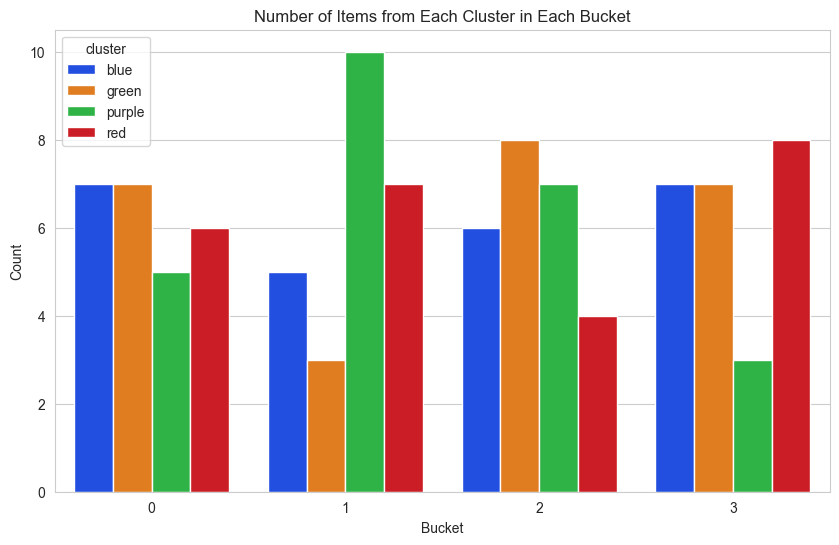

In [6]:
# Convert bucket assignments to a label
bucket_labels = [''.join(map(str, bucket)) for bucket in bucket_assignment]
data['bucket'] = bucket_labels

# Aggregate data: Count the number of points from each cluster in each bucket
bucket_cluster_counts = data.groupby(['bucket', 'cluster']).size().unstack(fill_value=0)

# Prepare the data for plotting
plot_data = bucket_cluster_counts.reset_index().melt(id_vars='bucket', var_name='cluster', value_name='count')

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_data, x='bucket', y='count', hue='cluster', palette='bright')
plt.title('Number of Items from Each Cluster in Each Bucket')
plt.xlabel('Bucket')
plt.ylabel('Count')
plt.show()

In [7]:
cluster_color = "purple"
filter_color = "red"
results = collection.query(
    query_embeddings=list(data[data['cluster'] == 'purple'][['x', 'y']].iloc[0]),
    include=["metadatas", 'embeddings', 'distances'],
    where={"cluster": filter_color},
    n_results=10,
    n_buckets=4,
    use_threshold=False, # TODO: this causes problems, hotfix applied for now
)

[2023-12-16 20:22:28,811][INFO ][chromadb.lmi.lmi.LMI] Precompute bucket order time: 0.0
100%|██████████| 4/4 [00:00<?, ?it/s]


In [8]:
print(results['ids'])
print(results['distances'])
print(results['metadatas'])

[['id99', 'id99', 'id99', 'id99', 'id99', 'id99', 'id99', 'id99', 'id99', 'id99']]
[[0.0033500960156713777, 0.0033500960156713777, 0.0033500960156713777, 0.0033500960156713777, 0.0033500960156713777, 0.0033500960156713777, 0.0033500960156713777, 0.0033500960156713777, 0.0033500960156713777, 0.0033500960156713777]]
[[{'cluster': 'purple'}, {'cluster': 'purple'}, {'cluster': 'purple'}, {'cluster': 'purple'}, {'cluster': 'purple'}, {'cluster': 'purple'}, {'cluster': 'purple'}, {'cluster': 'purple'}, {'cluster': 'purple'}, {'cluster': 'purple'}]]


In [9]:
bucket_order = results['bucket_order'][0]
cluster_specific_counts = bucket_cluster_counts[cluster_color]
order_labels = [''.join(map(str, bucket)) for bucket in bucket_order]

ordered_counts = cluster_specific_counts.reindex(order_labels, fill_value=0).reset_index()
ordered_counts.columns = ['bucket', 'count']

[2023-12-16 20:22:28,888][INFO ][matplotlib.category] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2023-12-16 20:22:28,888][INFO ][matplotlib.category] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


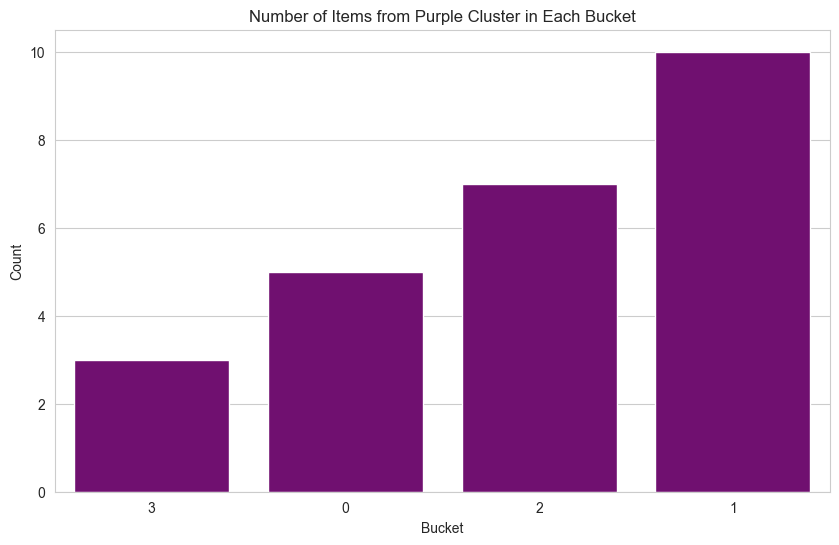

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(data=ordered_counts, x='bucket', y='count', color=cluster_color)
plt.title(f'Number of Items from {cluster_color.capitalize()} Cluster in Each Bucket')
plt.xlabel('Bucket')
plt.ylabel('Count')
plt.show()